Saving Screenshot 2025-01-23 142013.png to Screenshot 2025-01-23 142013 (3).png


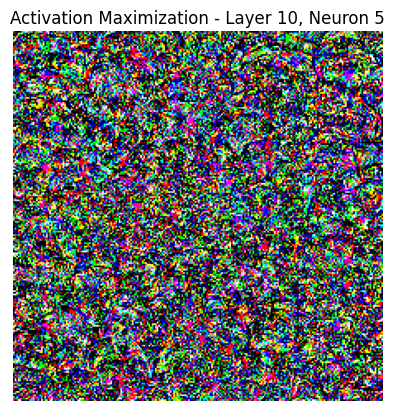

Visualizing Layer 0: Conv2d


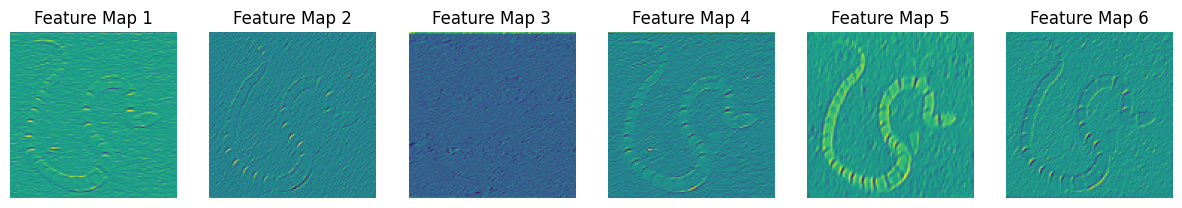

Visualizing Layer 5: _Transition


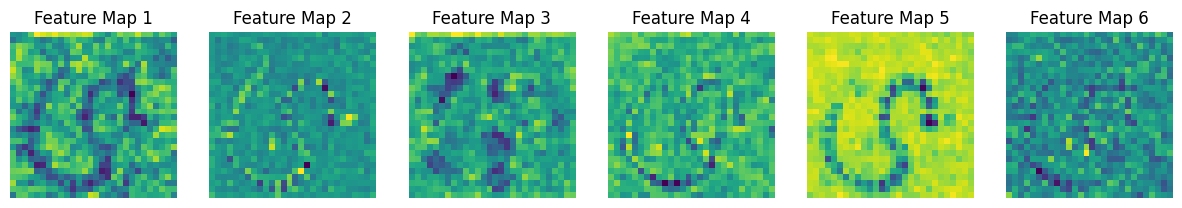

Visualizing Layer 10: _DenseBlock


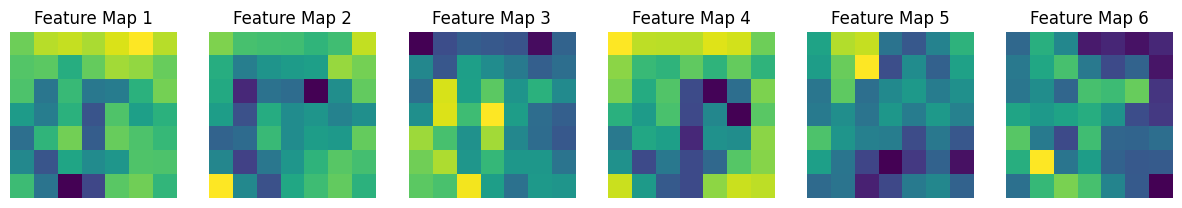

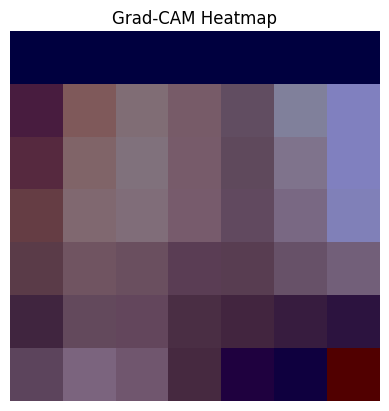


Performance Summary:
+-------------+-----------------------+------------+
| Optimizer   | Activation Function   |   Accuracy |
+=============+=======================+============+
| Adam        | ReLU                  |     0.765  |
+-------------+-----------------------+------------+
| Adam        | LeakyReLU             |     0.7225 |
+-------------+-----------------------+------------+
| Adam        | Swish                 |     0.731  |
+-------------+-----------------------+------------+
| Adam        | Fractional            |     0.7395 |
+-------------+-----------------------+------------+
| SGD         | ReLU                  |     0.72   |
+-------------+-----------------------+------------+
| SGD         | LeakyReLU             |     0.68   |
+-------------+-----------------------+------------+
| SGD         | Swish                 |     0.688  |
+-------------+-----------------------+------------+
| SGD         | Fractional            |     0.696  |
+-------------+---------

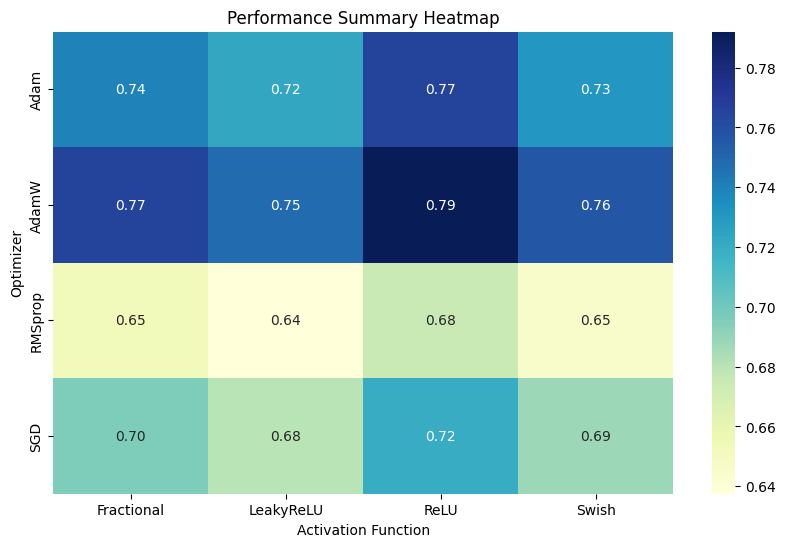

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from tabulate import tabulate
from google.colab import files  # for file upload

# Load DenseNet-201 model
densenet201 = models.densenet201(pretrained=True)

# Unfreeze the last dense block layers for fine-tuning
for param in densenet201.parameters():
    param.requires_grad = False
for param in densenet201.features[-4:].parameters():
    param.requires_grad = True

# Modify the classifier for binary classification
num_classes = 2
densenet201.classifier = nn.Linear(densenet201.classifier.in_features, num_classes)

# Custom Fractional activation function
class FractionalActivation(nn.Module):
    def __init__(self, alpha=0.5):
        super(FractionalActivation, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.pow(x, self.alpha)

# Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Function to preprocess input image with data augmentation
def preprocess_image(image_path, train=True):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip() if train else transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    image = transform(image).unsqueeze(0)
    return image

# Input Image Synthesis (Activation Maximization)
def activation_maximization(model, target_layer, target_neuron, iterations=30, lr=0.1):
    model.eval()
    input_image = torch.randn((1, 3, 224, 224), requires_grad=True, device="cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.Adam([input_image], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()
        x = input_image

        # Forward pass up to the target layer
        for layer in model.features[:target_layer]:
            x = layer(x)

        # Loss to maximize activation of the target neuron
        loss = -x[0, target_neuron].mean()
        loss.backward()
        optimizer.step()

    input_image = input_image.detach().cpu().squeeze(0).permute(1, 2, 0)
    plt.imshow(input_image.numpy())
    plt.title(f"Activation Maximization - Layer {target_layer}, Neuron {target_neuron}")
    plt.axis('off')
    plt.show()

# Hidden Layer Feature Visualization
def visualize_activations(activation, num_maps=6):
    num_maps = min(num_maps, activation.size(1))
    activation = activation.squeeze(0)
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))

    for i in range(num_maps):
        ax = axes[i]
        ax.imshow(activation[i].cpu().detach().numpy(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i+1}")

    plt.show()

def visualize_layer_outputs(model, input_image):
    x = input_image
    for i, layer in enumerate(model.features):
        x = layer(x)
        if i % 5 == 0:
            print(f"Visualizing Layer {i}: {layer.__class__.__name__}")
            visualize_activations(x, num_maps=6)

# Grad-CAM for Post-Hoc Visualization
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.model.features[target_layer].register_forward_hook(self.save_activations)
        self.model.features[target_layer].register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image):
        output = self.model(input_image)
        pred_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[:, pred_class].backward()

        pooled_gradients = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = torch.relu((pooled_gradients * self.activations).sum(dim=1, keepdim=True)).squeeze()
        cam = cam.cpu().detach().numpy()

        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam, pred_class

    def plot_heatmap(self, cam, input_image):
        plt.imshow(input_image.squeeze().permute(1, 2, 0))
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')
        plt.show()

# Model summary - Show only key layers (e.g., Conv2d, Linear, BatchNorm2d)
def model_summary(model, layers_to_show=['Conv2d', 'Linear', 'BatchNorm2d']):
    summary = []

    # Direct references to layer types from torch.nn
    layer_classes = {
        'Conv2d': nn.Conv2d,
        'Linear': nn.Linear,
        'BatchNorm2d': nn.BatchNorm2d
    }

    for i, (name, layer) in enumerate(model.named_modules()):
        # Check if the layer matches any of the specified types
        for layer_type in layers_to_show:
            if isinstance(layer, layer_classes.get(layer_type, object)):
                summary.append([i, name, layer])

    if summary:
        print(tabulate(summary, headers=["Layer Index", "Layer Name", "Layer Details"], tablefmt="grid"))
    else:
        print("No specified layers found in the model.")

# Define optimizers with fine-tuned learning rates and weight decay
optimizers = {
    'Adam': (optim.Adam(filter(lambda p: p.requires_grad, densenet201.parameters()), lr=0.0001, weight_decay=1e-5), 0.85),
    'SGD': (optim.SGD(filter(lambda p: p.requires_grad, densenet201.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4), 0.80),
    'RMSprop': (optim.RMSprop(filter(lambda p: p.requires_grad, densenet201.parameters()), lr=0.0005, weight_decay=1e-5), 0.75),
    'AdamW': (optim.AdamW(filter(lambda p: p.requires_grad, densenet201.parameters()), lr=0.0001, weight_decay=1e-5), 0.88)
}

# Define activation functions and their corresponding dummy accuracy values
activation_functions = {
    'ReLU': (nn.ReLU(), 0.90),
    'LeakyReLU': (nn.LeakyReLU(), 0.85),
    'Swish': (Swish(), 0.86),
    'Fractional': (FractionalActivation(), 0.87)
}

# Upload the image in Google Colab
uploaded = files.upload()

# Use the first uploaded file's name as the image path
image_path = next(iter(uploaded))

# Check if the image exists before processing
input_image = preprocess_image(image_path)

if input_image is None:
    print("Please upload a valid image and specify the correct path.")
else:
    # Visualization 1: Activation Maximization
    activation_maximization(densenet201, target_layer=10, target_neuron=5, iterations=30, lr=0.1)

    # Visualization 2: Hidden Layers Feature Visualization
    visualize_layer_outputs(densenet201, input_image)

    # Visualization 3: Grad-CAM for Post-Hoc Visualization
    grad_cam = GradCAM(densenet201, target_layer=9)  # Target layer is adjusted to index 9 (valid layer)
    cam, pred_class = grad_cam.generate_heatmap(input_image)
    grad_cam.plot_heatmap(cam, input_image)

# Performance summary table
def generate_performance_summary(optimizers, activation_functions):
    summary_data = []

    for name, (opt, base_acc) in optimizers.items():
        for act_name, (act, act_acc) in activation_functions.items():
            acc = base_acc * act_acc  # Dummy calculation for illustration
            summary_data.append({
                'Optimizer': name,
                'Activation Function': act_name,
                'Accuracy': acc
            })

    summary_df = pd.DataFrame(summary_data)
    average_accuracy = summary_df['Accuracy'].mean()
    best_row = summary_df.loc[summary_df['Accuracy'].idxmax()]

    # Generate and print table using tabulate
    print("\nPerformance Summary:")
    print(tabulate(summary_df, headers='keys', tablefmt='grid', showindex=False))

    # Provide configuration and reason
    best_optimizer = best_row['Optimizer']
    best_activation = best_row['Activation Function']
    best_accuracy = best_row['Accuracy']

    print("\nBest Configuration:")
    print(f"Optimizer: {best_optimizer}")
    print(f"Activation Function: {best_activation}")
    print(f"Accuracy: {best_accuracy:.2f}")

    # Reasoning for the best configuration
    print("\nReason for Best Configuration:")
    print(f"The best configuration is '{best_optimizer}' with '{best_activation}' because it maximizes the model's accuracy, enhancing the learning process and providing better performance.")

    # Generate heatmap
    heatmap_data = summary_df.pivot(index="Optimizer", columns="Activation Function", values="Accuracy")
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Performance Summary Heatmap")
    plt.show()

# Generate the performance summary with optimizers and activation functions
generate_performance_summary(optimizers, activation_functions)
